In [1]:
import numpy as np
def calculate_error_rate(y_pred, y, test_type=""):
    num_errors = np.sum(y_pred != y)
    n = y_pred.shape[0]
    error_rate = (num_errors / n) * 100
    print(f"{test_type} error rate: {error_rate:.2f}%")


In [2]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat

# Load the dataset
data = loadmat('data/classifier_dataset.mat')

# Extract variables
X_train = data['traindataset']     # Training data (400 x 784)
y_train = data['trainlabels'].flatten()  # Training labels (400,)
N_train, D = X_train.shape

X_test = data['testdataset']       # Test data (1600 x 784)
y_test = data['testlabels'].flatten()    # Test labels (1600,)
N_test = X_test.shape[0]

# Regularization parameter
rho = 0.1
# rho = 0.5

# Define variables for optimization
w0 = cp.Variable()  # Scalar bias term
w = cp.Variable(D)  # Weight vector of size D

# Define the hinge loss function
u = cp.multiply(y_train, w0 + X_train @ w)  # y_n * (w0 + x_n.T @ w)
loss = (1 / N_train) * cp.sum(cp.pos(1 - u))  # Hinge loss
reg = rho * cp.norm(w, 2)**2  # Regularization term
objective = cp.Minimize(loss + reg)

# Solve the optimization problem
problem = cp.Problem(objective)
problem.solve()

# Extract optimal parameters
w0_value = w0.value
w_value = w.value

# Compute predictions and error rate on training data
scores_train = w0_value + X_train @ w_value  # Scores for training data
y_pred_train = np.sign(scores_train)         # Predicted labels for training data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_train[scores_train == 0] = 1


calculate_error_rate(y_pred_train, y_train, "Training")

scores_test = w0_value + X_test @ w_value    # Scores for test data
y_pred_test = np.sign(scores_test)           # Predicted labels for test data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test[scores_test == 0] = 1


calculate_error_rate(y_pred_test, y_test, "Test")


(CVXPY) Oct 25 07:34:38 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 25 07:34:38 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


FileNotFoundError: [Errno 2] No such file or directory: 'data/classifier_dataset.mat'

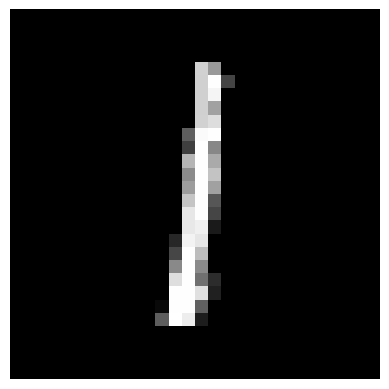

Label: 1


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_im(x):
    # Reshape the flattened image back to 28x28
    image = x.reshape(28, 28).T  # Transpose to match the original orientation
    
    # Rescale the image data to [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    image_rescaled = (image - min_val) / (max_val - min_val) * 255
    
    # Display the image
    plt.imshow(image_rescaled, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    
# Example usage
sample_index = 1  # Change this index to view different images
show_im(X_test[sample_index])
print(f'Label: {y_test[sample_index]}')  # -1 for digit 0, 1 for digit 1


In [9]:
## Adversarial Attack Implementation

def compute_perturbation(X, y, w, P):
    """
    Computes the optimal perturbation for a set of inputs.

    Parameters:
    - X: Input data matrix (N x D)
    - y: True labels vector (N,)
    - w: Weight vector of the classifier (D,)
    - P: Perturbation bound (scalar)

    Returns:
    - X_adv: Adversarially perturbed data matrix (N x D)
    """
    # Compute sign(y * w) for each feature
    sign_yw = np.sign(y[:, np.newaxis] * w[np.newaxis, :])  # Shape: (N, D)
    
    # Compute perturbation
    perturbation = P * sign_yw  # Shape: (N, D)
    
    # Apply perturbation: x̃ = x - P * sign(yw)
    X_adv = X - perturbation
    
    # Ensure perturbations are within [-P, P]
    X_adv = np.clip(X_adv, X - P, X + P)
    
    return X_adv

# Define perturbation magnitude P
P = 0.18  # Adjust as needed

# Generate adversarial examples for the test set
X_test_adv = compute_perturbation(X_test, y_test, w_value, P)

# Compute predictions on adversarial test data
scores_test_adv = w0_value + X_test_adv @ w_value
y_pred_test_adv = np.sign(scores_test_adv)
y_pred_test_adv[scores_test_adv == 0] = 1

# Calculate error rate on adversarial test data
calculate_error_rate(y_pred_test_adv, y_test, "Adversarial Test")

Adversarial Test error rate: 43.56%


In [10]:
# Regularization parameter
rho = 0.1

# Perturbation bound
P = 0.18  # You can adjust this value as needed

# Define variables for optimization
w0 = cp.Variable()      # Scalar bias term
w = cp.Variable(D)      # Weight vector of size D

# Compute ||w||_1 once, since it's the same for all samples
w_l1 = cp.norm1(w)


# Define the adjusted hinge loss
# For each sample: h(y_n (w0 + x_n^T w) - P ||w||_1), note that ||w*y||_1 = ||w||_1 because y = {-1, 1}
u = cp.multiply(y_train, w0 + X_train @ w) - P * w_l1
#  y_train * (w0 + X_train @ w) - P * w_l1  # Shape: (N_train,)

# Hinge loss: max(0, 1 - u)
loss = (1 / N_train) * cp.sum(cp.pos(1 - u))

# Regularization term
reg = rho * cp.norm(w, 2)**2  # L2 regularization

# Objective function
objective = cp.Minimize(loss + reg)

# Define and solve the problem
problem = cp.Problem(objective)
problem.solve()

# Extract optimal parameters
w0_value = w0.value
w_value = w.value

# Compute predictions on training data
scores_train = w0_value + X_train @ w_value  # Scores for training data
y_pred_train = np.sign(scores_train)         # Predicted labels for training data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_train[scores_train == 0] = 1

# Calculate error rate on training data
calculate_error_rate(y_pred_train, y_train, "Training")

# Compute predictions on test data
scores_test = w0_value + X_test @ w_value    # Scores for test data
y_pred_test = np.sign(scores_test)           # Predicted labels for test data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test[scores_test == 0] = 1

# Calculate error rate on test data
calculate_error_rate(y_pred_test, y_test, "Test")

# Generate adversarial examples for the test set
X_test_adv = compute_perturbation(X_test, y_test, w_value, P)

# Compute predictions on adversarial test data
scores_test_adv = w0_value + X_test_adv @ w_value
y_pred_test_adv = np.sign(scores_test_adv)

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test_adv[scores_test_adv == 0] = 1

# Calculate error rate on adversarial test data
calculate_error_rate(y_pred_test_adv, y_test, "Adversarial Test")


Training error rate: 0.75%
Test error rate: 0.44%
Adversarial Test error rate: 2.19%


In [7]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load data from lm_dataset_task.mat
data = scipy.io.loadmat('data/lm_dataset_check.mat')

x = data['x'].flatten()  # Time instants (N,)
y = data['y'].flatten()  # Measurements (N,)
s = data['s'].flatten()  # Initial slopes (K,)
r = data['r'].flatten()  # Initial intercepts (K,)
u = data['u'].flatten()  # Initial u parameters (K-1,)
v = data['v'].flatten()  # Initial v parameters (K-1,)

# Constants
K = len(s)      # Number of linear models
N = len(x)      # Number of data points
print(f'K = {K}, N = {N}')

K = 4, N = 100


In [8]:
def compute_weights(x_n, u, v):
    # Append u_K = 0 and v_K = 0
    u_full = np.append(u, 0)
    v_full = np.append(v, 0)
    
    alpha = u_full * x_n + v_full
    max_alpha = np.max(alpha)
    exp_alpha = np.exp(alpha - max_alpha)
    sum_exp_alpha = np.sum(exp_alpha)
    w = exp_alpha / sum_exp_alpha
    return w

def compute_y_hat(x_n, s, r, u, v):
    y_hat = np.zeros_like(x_n)
    for i in range(N):
        w = compute_weights(x_n[i], u, v)
        y_k = s * x_n[i] + r
        y_hat[i] = np.dot(w, y_k)
    return y_hat

def compute_gradient(x, y, s, r, u, v):
    # Initialize gradient vector
    grad_s = np.zeros_like(s)
    grad_r = np.zeros_like(r)
    grad_u = np.zeros_like(u)
    grad_v = np.zeros_like(v)
    
    for i in range(N):
        x_n = x[i]
        y_n = y[i]
        # Compute weights and y_k
        w = compute_weights(x_n, u, v)
        y_k = s * x_n + r
        y_hat_n = np.dot(w, y_k)
        residual = y_hat_n - y_n
        
        # Partial derivatives w.r.t s_k and r_k
        for k in range(K):
            # w_k for current x_n
            w_k = w[k]
            # Derivative w.r.t s_k
            grad_s[k] += 2 * residual * w_k * x_n
            # Derivative w.r.t r_k
            grad_r[k] += 2 * residual * w_k
        
        # Partial derivatives w.r.t u_k and v_k (for k = 1 to K-1)
        for k in range(K - 1):
            # Compute partial derivatives of w_k
            u_full = np.append(u, 0)
            v_full = np.append(v, 0)
            alpha = u_full * x_n + v_full
            max_alpha = np.max(alpha)
            exp_alpha = np.exp(alpha - max_alpha)
            sum_exp_alpha = np.sum(exp_alpha)
            w_full = exp_alpha / sum_exp_alpha
            
            # Derivatives of w_k w.r.t u_k and v_k
            w_k = w_full[k]
            y_k = s[k] * x_n + r[k]
            # Compute sum over l
            sum_over_l = np.sum(w_full * y_k)
            d_wk_duk = w_k * (1 - w_k) * x_n
            d_wk_dvk = w_k * (1 - w_k)
            # Derivative of y_hat w.r.t u_k and v_k
            grad_u[k] += 2 * residual * (y_k - y_hat_n) * d_wk_duk
            grad_v[k] += 2 * residual * (y_k - y_hat_n) * d_wk_dvk
    # Combine gradients into a single vector
    grad = np.concatenate([grad_s, grad_r, grad_u, grad_v])
    return grad




In [9]:
# Initial parameter vector
theta = np.concatenate([s, r, u, v])

# LM parameters
lambda_k = 1.0
epsilon = 1e-4
max_iterations = 5000
k = 0

# To store history for plotting
objective_history = []
gradient_norm_history = []

# Start LM iterations
while k < max_iterations:
    # Compute current parameters
    s_k = theta[:K]
    r_k = theta[K:2*K]
    u_k = theta[2*K:2*K + (K - 1)]
    v_k = theta[2*K + (K - 1):]
    
    # Compute residuals and objective function
    y_hat = compute_y_hat(x, s_k, r_k, u_k, v_k)
    residuals = y_hat - y
    f_theta = np.sum(residuals**2)
    
    # Compute gradient
    grad = compute_gradient(x, y, s_k, r_k, u_k, v_k)
    gradient_norm = np.linalg.norm(grad)
    
    # Store for plotting
    objective_history.append(f_theta)
    gradient_norm_history.append(gradient_norm)
    
    # Check stopping criterion
    if gradient_norm < epsilon:
        print(f'Converged at iteration {k}')
        break
    
    # Compute Jacobian matrix J numerically
    # Since the Jacobian is large, we approximate it using finite differences
    # Alternatively, we can analytically compute it, but due to complexity, we proceed numerically here
    
    # Number of parameters
    num_params = len(theta)
    J = np.zeros((N, num_params))
    delta = 1e-8
    for j in range(num_params):
        theta_plus = theta.copy()
        theta_plus[j] += delta
        # Compute y_hat with perturbed parameter
        s_plus = theta_plus[:K]
        r_plus = theta_plus[K:2*K]
        u_plus = theta_plus[2*K:2*K + (K - 1)]
        v_plus = theta_plus[2*K + (K - 1):]
        y_hat_plus = compute_y_hat(x, s_plus, r_plus, u_plus, v_plus)
        residuals_plus = y_hat_plus - y
        # Compute numerical derivative
        J[:, j] = (residuals_plus - residuals) / delta
    
    # Compute Hessian approximation
    H = J.T @ J + lambda_k * np.eye(num_params)
    # Compute parameter update
    delta_theta = -np.linalg.solve(H, J.T @ residuals)
    
    # Compute candidate theta
    theta_new = theta + delta_theta
    # Compute new residuals and objective function
    s_new = theta_new[:K]
    r_new = theta_new[K:2*K]
    u_new = theta_new[2*K:2*K + (K - 1)]
    v_new = theta_new[2*K + (K - 1):]
    y_hat_new = compute_y_hat(x, s_new, r_new, u_new, v_new)
    residuals_new = y_hat_new - y
    f_theta_new = np.sum(residuals_new**2)
    
    # Update based on improvement
    if f_theta_new < f_theta:
        # Valid step
        theta = theta_new
        lambda_k *= 0.7
    else:
        # Null step
        lambda_k *= 2.0
    k += 1
else:
    print('Maximum iterations reached without convergence.')


/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_38036/205796576.py:62: RuntimeWarning: invalid value encountered in multiply
  H = J.T @ J + lambda_k * np.eye(num_params)


Maximum iterations reached without convergence.


In [10]:
# Extract final parameters
s_final = theta[:K]
r_final = theta[K:2*K]
u_final = theta[2*K:2*K + (K - 1)]
v_final = theta[2*K + (K - 1):]

print('Final parameter values after convergence:')
print('s (slopes):', s_final)
print('r (intercepts):', r_final)
print('u (weight parameters):', u_final)
print('v (weight parameters):', v_final)


Final parameter values after convergence:
s (slopes): [ -3.5599035   -0.56765217  -0.0231897  -10.11858149]
r (intercepts): [23.48753316 14.01484902 33.98376786 51.24357545]
u (weight parameters): [-155.06553438   81.22668635  -94.90692562]
v (weight parameters): [-156.7444086  -417.1791461   104.18751391]


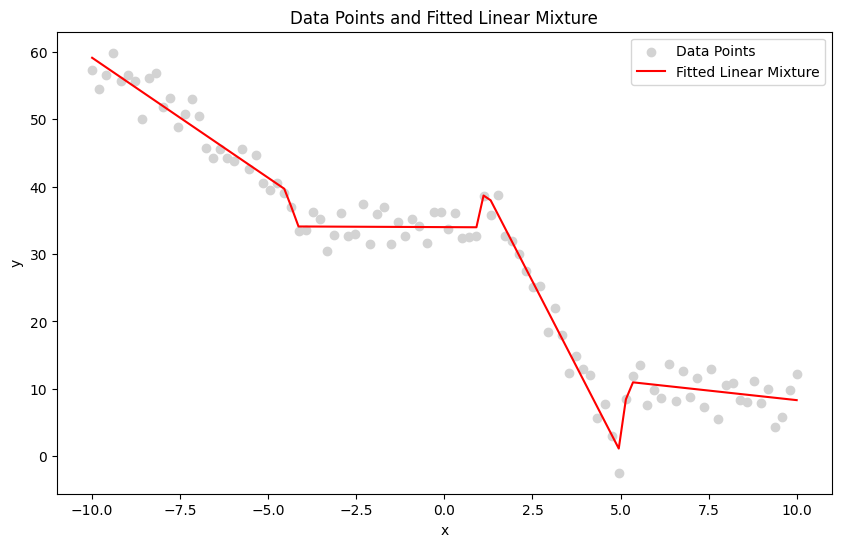

In [13]:
# Compute final y_hat
y_hat_final = compute_y_hat(x, s_final, r_final, u_final, v_final)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data Points', color='lightgray')
plt.plot(x, y_hat_final, label='Fitted Linear Mixture', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Points and Fitted Linear Mixture')
plt.legend()
plt.show()


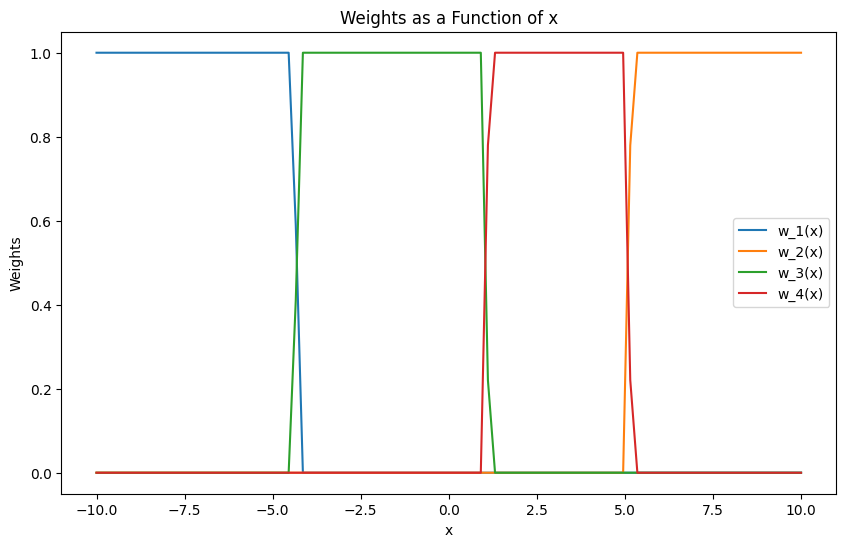

In [14]:
# Compute weights for each x_n
weights = np.zeros((N, K))
for i in range(N):
    weights[i, :] = compute_weights(x[i], u_final, v_final)

plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(x, weights[:, k], label=f'w_{k+1}(x)')
plt.xlabel('x')
plt.ylabel('Weights')
plt.title('Weights as a Function of x')
plt.legend()
plt.show()


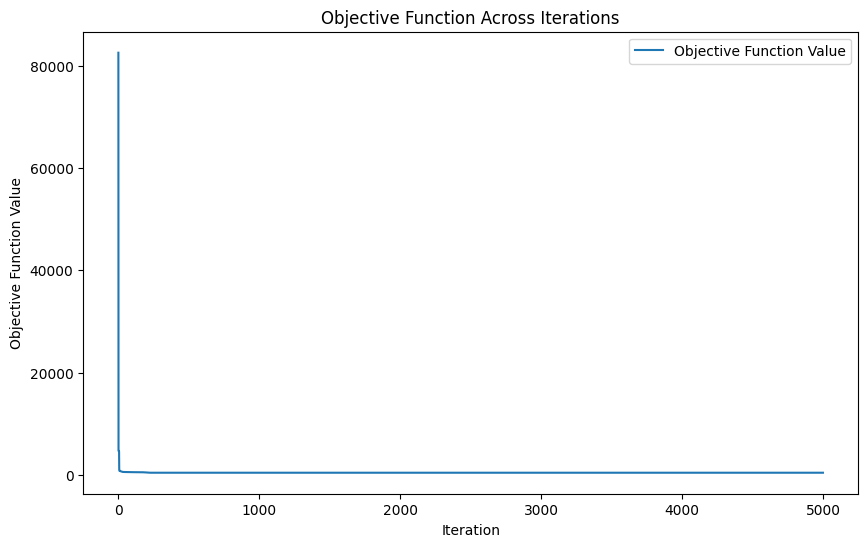

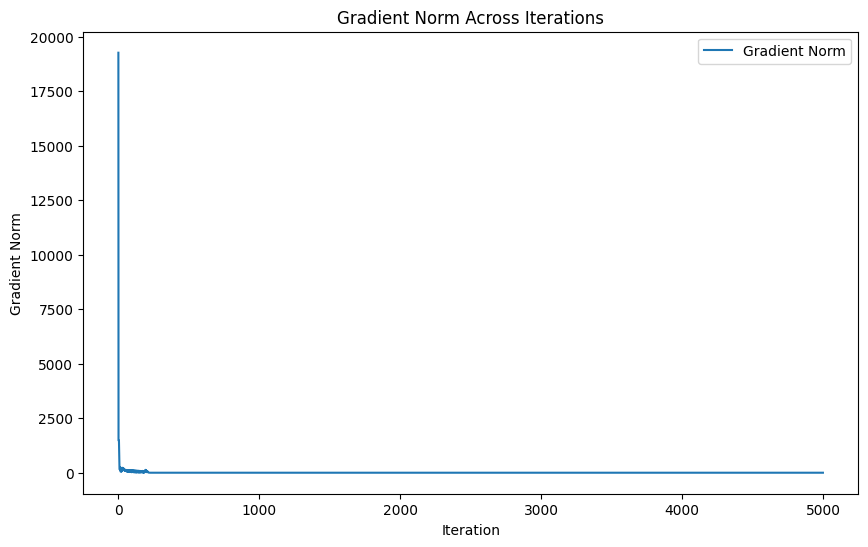

In [15]:
iterations = range(len(objective_history))

plt.figure(figsize=(10, 6))
plt.plot(iterations, objective_history, label='Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Across Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(iterations, gradient_norm_history, label='Gradient Norm')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Across Iterations')
plt.legend()
plt.show()
